In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np
import pandas as pd
import math

data = pd.read_csv('SCADA-FINAL.csv')
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y-%m-%d %H:%M:%S')
data.set_index('Timestamp', inplace=True)

# Convert DayOfWeek to radians
data['DayOfWeek'] = data.index.weekday
data['t'] = (data['DayOfWeek'] / 6) * 2 * np.pi
d= 1
z = d+1
# Calculate sine and cosine values for multiple angles
angle_cols = []
for i in range(1, z):  # 1 to z
    angle = i * data['t']
    angle_cols.append(pd.Series(np.sin(angle), name=f'sin({i}t)'))
    angle_cols.append(pd.Series(np.cos(angle), name=f'cos({i}t)'))

# Concatenate all angle columns to the DataFrame
data = pd.concat([data] + angle_cols, axis=1)

data.drop(columns=['t','DayOfWeek','day_sin', 'day_cos', 'D2_TEMPERATURE', 'Q-influent_MGD'
                  ], inplace=True)

# Check the last few features
print(data.iloc[:, -7:])
data.columns

                     Q-TWAS_GPM_prev_24h_1  Q-TWAS_GPM_prev_24h_2  \
Timestamp                                                           
2022-03-23 00:00:00               9.039250               8.843972   
2022-03-23 00:01:00               9.039250               8.843986   
2022-03-23 00:02:00               9.039264               8.843986   
2022-03-23 00:03:00               9.039278               8.843972   
2022-03-23 00:04:00               9.039278               8.843986   
...                                    ...                    ...   
2023-02-27 20:00:00              13.753083              14.619479   
2023-02-27 20:01:00              13.787750              14.619479   
2023-02-27 20:02:00              13.822257              14.619493   
2023-02-27 20:03:00              13.856660              14.619507   
2023-02-27 20:04:00              13.891243              14.619521   

                     Q-TWAS_GPM_prev_24h_3  Q-TWAS_GPM_prev_24h_4    Forecast  \
Timestamp            

Index(['D1_TEMPERATURE', 'Q-PS_MGD', 'Q-TWAS_GPM', 'V-Boiler_FT3', 'H-HSW_ft',
       'H-Dig1_FT', 'H-Dig2_FT', 'Biogas_burner', 'Biogas_boiler', 'Q-HSW_GPM',
       'Biogas_prev_hour_avg', 'hour_sin', 'hour_cos', 'H-Dig1-deriv_FTpermin',
       'H-Dig2-deriv_FTpermin', 'V-burner_FT3-2', 'Q-PS_MGD_prev_24h',
       'Q-TWAS_GPM_prev_24h', 'Q-HSW_GPM_prev_24h', 'Biogas_prev_24h',
       'Biogas_prev_24h_1', 'Biogas_prev_24h_2', 'Biogas_prev_24h_3',
       'Biogas_prev_24h_4', 'Q-HSW_GPM_prev_24h_1', 'Q-HSW_GPM_prev_24h_2',
       'Q-HSW_GPM_prev_24h_3', 'Q-HSW_GPM_prev_24h_4', 'Q-PS_MGD_prev_24h_1',
       'Q-PS_MGD_prev_24h_2', 'Q-PS_MGD_prev_24h_3', 'Q-PS_MGD_prev_24h_4',
       'Q-TWAS_GPM_prev_24h_1', 'Q-TWAS_GPM_prev_24h_2',
       'Q-TWAS_GPM_prev_24h_3', 'Q-TWAS_GPM_prev_24h_4', 'Forecast', 'sin(1t)',
       'cos(1t)'],
      dtype='object')

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

x_train, x_test, y_train, y_test = train_test_split(
    data.drop('Forecast', axis=1), data['Forecast'], test_size=0.2,
    shuffle=False)

# Initialize scaler object
scaler = StandardScaler()
z2=z-1
# Fit the scaler on the training dataset, but we have to exclude the sine and cosine terms
scaler.fit(x_train.iloc[:, :-z2])

# Transform the training and testing dataset
x_train_s = pd.DataFrame(scaler.transform(x_train.iloc[:, :-z2]), index=x_train.index)
x_test_s = pd.DataFrame(scaler.transform(x_test.iloc[:, :-z2]), index=x_test.index)


# Combine sine and cosine terms
x_train_s = pd.concat([x_train_s, x_train.iloc[:, -z2:]], axis=1, ignore_index=True)
x_test_s = pd.concat([x_test_s, x_test.iloc[:, -z2:]], axis=1, ignore_index=True)

# Add the column names back
x_train_s.columns = x_train.columns
x_test_s.columns = x_test.columns

# Check to make sure everything looks right
x_train_s

,D1_TEMPERATURE,Q-PS_MGD,Q-TWAS_GPM,V-Boiler_FT3,H-HSW_ft,H-Dig1_FT,H-Dig2_FT,Biogas_burner,Biogas_boiler,Q-HSW_GPM,...,Q-PS_MGD_prev_24h_1,Q-PS_MGD_prev_24h_2,Q-PS_MGD_prev_24h_3,Q-PS_MGD_prev_24h_4,Q-TWAS_GPM_prev_24h_1,Q-TWAS_GPM_prev_24h_2,Q-TWAS_GPM_prev_24h_3,Q-TWAS_GPM_prev_24h_4,sin(1t),cos(1t)
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-23 00:00:00,-0.568071,-0.191843,-0.339807,3.033354,-0.518552,0.467235,1.786058,0.959180,1.270919,0.848766,...,-0.485030,-0.429640,-0.427304,-0.380711,0.621969,0.564729,0.600907,0.720826,1.318438,-0.5
2022-03-23 00:01:00,-0.469175,5.150879,-0.339807,-1.359258,-0.508768,0.483399,1.786058,0.939302,1.304285,0.848766,...,-0.462671,-0.429839,-0.438358,-0.389442,0.621969,0.564733,0.588226,0.733499,1.318438,-0.5
2022-03-23 00:02:00,-0.644991,5.042593,-0.339807,-1.354836,-0.498985,0.483399,1.786058,0.931350,1.316394,0.882829,...,-0.440125,-0.435584,-0.447302,-0.394109,0.621973,0.564733,0.588230,0.733491,1.318438,-0.5
2022-03-23 00:03:00,-0.491152,-0.191843,-0.339807,-1.350406,-0.479417,0.483399,1.786058,0.890267,1.313434,0.847550,...,-0.453339,-0.442693,-0.426987,-0.394113,0.621977,0.564729,0.588234,0.733487,1.318438,-0.5
2022-03-23 00:04:00,-0.568071,-0.191843,-0.339807,-1.345978,-0.489201,0.483399,1.786058,0.927374,1.316394,0.847550,...,-0.453339,-0.460705,-0.408983,-0.394113,0.621977,0.564733,0.588234,0.733483,1.318438,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-21 12:47:00,-0.084576,-0.192523,-0.340818,0.917007,0.684853,1.097632,2.144065,1.673486,1.881204,0.851199,...,-0.088183,-0.075908,-0.008870,0.050406,0.293713,0.483171,0.375190,0.150280,1.318438,-0.5
2022-12-21 12:48:00,-0.117542,-0.192523,-0.339807,0.922629,0.684853,1.097632,2.144065,1.665535,1.939864,0.848766,...,-0.088183,-0.075911,-0.008867,0.050406,0.293721,0.483167,0.375186,0.150284,1.318438,-0.5
2022-12-21 12:49:00,-0.051611,-0.192523,-0.340818,0.928309,0.675069,1.097632,2.144065,1.693365,1.953050,0.885262,...,-0.088183,-0.075911,-0.008870,0.050409,0.293717,0.473164,0.385194,0.150284,1.318438,-0.5


In [3]:
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# Assuming 'column_names' is the list of column names and 'columns_to_drop' is a list of column names to be dropped
column_names = x_train.columns  # List of column names
columns_to_drop = ['D1_TEMPERATURE', 'D2_TEMPERATURE', 'Q-PS_MGD', 'Q-influent_MGD',
       'Q-TWAS_GPM', 'V-Boiler_FT3', 'H-HSW_ft', 'H-Dig1_FT', 'H-Dig2_FT',
       'Biogas_burner', 'Biogas_boiler', 'Q-HSW_GPM', 'Biogas_prev_hour_avg',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'H-Dig1-deriv_FTpermin',
       'H-Dig2-deriv_FTpermin', 'V-burner_FT3-2', 'Q-PS_MGD_prev_24h',
       'Q-TWAS_GPM_prev_24h', 'Q-HSW_GPM_prev_24h', 'Biogas_prev_24h',
       'Biogas_prev_24h_1', 'Biogas_prev_24h_2', 'Biogas_prev_24h_3',
       'Biogas_prev_24h_4', 'Q-HSW_GPM_prev_24h_1', 'Q-HSW_GPM_prev_24h_2',
       'Q-HSW_GPM_prev_24h_3', 'Q-HSW_GPM_prev_24h_4', 'Q-PS_MGD_prev_24h_1',
       'Q-PS_MGD_prev_24h_2', 'Q-PS_MGD_prev_24h_3', 'Q-PS_MGD_prev_24h_4',
       'Q-TWAS_GPM_prev_24h_1', 'Q-TWAS_GPM_prev_24h_2',
       'Q-TWAS_GPM_prev_24h_3', 'Q-TWAS_GPM_prev_24h_4', 'Forecast']  # List of column names to be dropped

# Drop the specified columns
diurnal_cols = [col for col in column_names if col not in columns_to_drop]
no_diurnal_cols = ~x_train_s.columns.isin(diurnal_cols)



In [4]:
from sklearn.metrics import mean_absolute_percentage_error

cv = TimeSeriesSplit(gap = 300)
model_lm = RidgeCV(cv=cv) 

# Select all but the dirunal columns
no_diurnal_cols = ~x_train_s.columns.isin(diurnal_cols)

model_lm.fit(x_train_s.loc[:, no_diurnal_cols], y_train)

# Predict using the fitted model
y_train_lm = model_lm.predict(x_train_s.loc[:, no_diurnal_cols])
y_test_lm = model_lm.predict(x_test_s.loc[:, no_diurnal_cols])

mse_train_lm = mean_squared_error(y_train, y_train_lm)
mape_train_lm = mean_absolute_percentage_error(y_train, y_train_lm)
r2_train_lm = r2_score(y_train, y_train_lm)
rmse_train = math.sqrt(mse_train_lm)
mse_test_lm = mean_squared_error(y_test, y_test_lm)
mape_test_lm = mean_absolute_percentage_error(y_test, y_test_lm)
r2_test_lm = r2_score(y_test, y_test_lm)
rmse_test = math.sqrt(mse_test_lm)

# Print training and testing error
print(f"Training Mean Squared Error (MSE): {round(mse_train_lm,3)}")
print(f"Training Root Mean Squared Error (MSE): {round(rmse_train,3)}")
print(f"Training Mean Absolute Percentage Error (MAPE): {round(mape_train_lm,3)}")
print(f"Training R-squared (R2) Score: {round(r2_train_lm,3)}")
print(f"Testing Mean Squared Error (MSE): {round(mse_test_lm,3)}")
print(f"Testing Root Mean Squared Error (MSE): {round(rmse_test,3)}")
print(f"Testing Mean Absolute Percentage Error (MAPE): {round(mape_test_lm,3)}")
print(f"Testing R-squared (R2) Score: {round(r2_test_lm,3)}")

def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

n = len(x_test_s)  # Number of samples in test data
k = len(x_train_s.columns)-z  # Number of predictors in the model

# Calculate Adjusted R-squared
adjusted_r2_value = adjusted_r2(r2_test_lm, n, k)
print("Adjusted R-squared:", round(adjusted_r2_value,3))
print("Number of variables:", k)
TeEI = (mape_test_lm*mape_test_lm*rmse_test)/adjusted_r2_value
print("TeEI:", round(TeEI,3))

Training Mean Squared Error (MSE): 299.782
Training Root Mean Squared Error (MSE): 17.314
Training Mean Absolute Percentage Error (MAPE): 0.143
Training R-squared (R2) Score: 0.774
Testing Mean Squared Error (MSE): 438.53
Testing Root Mean Squared Error (MSE): 20.941
Testing Mean Absolute Percentage Error (MAPE): 0.137
Testing R-squared (R2) Score: 0.761
Adjusted R-squared: 0.761
Number of variables: 36
TeEI: 0.515


In [5]:
from regressors import stats
p = stats.coef_pval(model_lm, x_train_s.loc[:, no_diurnal_cols], y_train)
c = x_train_s.loc[:, no_diurnal_cols][:0]
p=np.around(p, decimals=3, out=None)
print(c)
print(p)
stats.summary(model_lm, x_train_s.loc[:, no_diurnal_cols], y_train)

Empty DataFrame
Columns: [D1_TEMPERATURE, Q-PS_MGD, Q-TWAS_GPM, V-Boiler_FT3, H-HSW_ft, H-Dig1_FT, H-Dig2_FT, Biogas_burner, Biogas_boiler, Q-HSW_GPM, Biogas_prev_hour_avg, hour_sin, hour_cos, H-Dig1-deriv_FTpermin, H-Dig2-deriv_FTpermin, V-burner_FT3-2, Q-PS_MGD_prev_24h, Q-TWAS_GPM_prev_24h, Q-HSW_GPM_prev_24h, Biogas_prev_24h, Biogas_prev_24h_1, Biogas_prev_24h_2, Biogas_prev_24h_3, Biogas_prev_24h_4, Q-HSW_GPM_prev_24h_1, Q-HSW_GPM_prev_24h_2, Q-HSW_GPM_prev_24h_3, Q-HSW_GPM_prev_24h_4, Q-PS_MGD_prev_24h_1, Q-PS_MGD_prev_24h_2, Q-PS_MGD_prev_24h_3, Q-PS_MGD_prev_24h_4, Q-TWAS_GPM_prev_24h_1, Q-TWAS_GPM_prev_24h_2, Q-TWAS_GPM_prev_24h_3, Q-TWAS_GPM_prev_24h_4]
Index: []

[0 rows x 36 columns]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.017 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.   ]
Residuals:
     Min       1Q  Median      3Q     Max
-81.4317 -10.0219  0.298

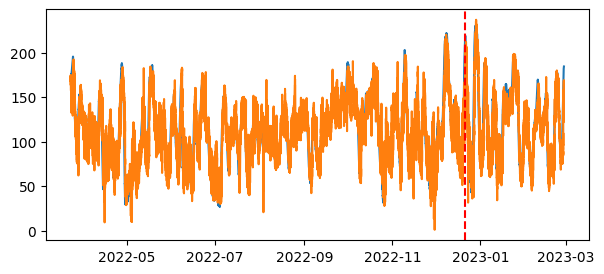

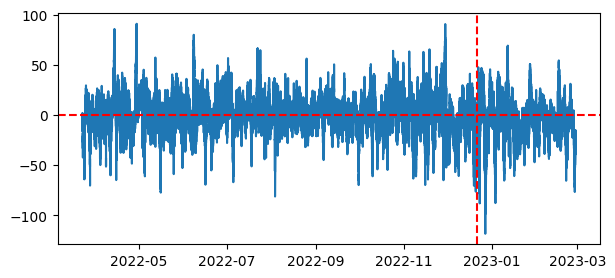

In [6]:
# Plot timeseries
fig = plt.figure(figsize=(7, 3))
x =  data.index
y1 = data['Forecast'] # Forecast
y2 = np.concatenate((y_train_lm, y_test_lm))
v = data.index[y_train_lm.shape[0]]
plt.plot(x, y1, label='actual')
plt.plot(x, y2, label='linear')
plt.axvline(x=v, color='r', linestyle='--')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))
plt.show()

# Plot residuals
fig = plt.figure(figsize=(7, 3))
x =  data.index
y1 = data['Forecast'] # Forecast
y2 = np.concatenate((y_train_lm, y_test_lm))
v = data.index[y_train_lm.shape[0]]
plt.plot(x, y2-y1, label='residuals')
plt.axvline(x=v, color='r', linestyle='--')
plt.axhline(y=0, color='r', linestyle='--')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

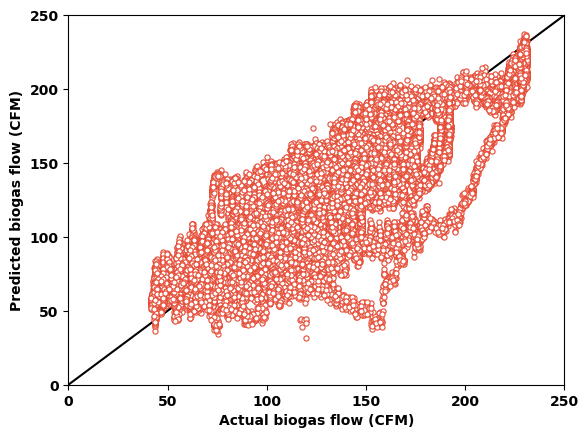

In [7]:
from matplotlib.font_manager import FontProperties
font_props = FontProperties(family='DejaVu Sans', weight='bold')

# Shuffle the data randomly
permutation = np.random.permutation(len(y_test))
y_tests = y_test[permutation]
y_test_lms = y_test_lm[permutation]

true_data = [0, 250]
plt.plot(true_data, true_data, 'k', zorder=1, label='_')

# Plot the shuffled predicted values
scatter = plt.scatter(y_tests, y_test_lms, marker='o', s=14, linewidths=0.8, edgecolors='#E64B35FF', facecolors='w', label='', zorder=2)

plt.xticks(rotation=0, fontproperties=font_props)
plt.yticks(fontproperties=font_props)

# Graph labels
plt.xlabel('Actual biogas flow (CFM)', fontproperties=font_props)
plt.ylabel('Predicted biogas flow (CFM)', font_properties=font_props)
plt.xlim(0, 250)
plt.ylim(0, 250)

plt.show

In [8]:
cv=TimeSeriesSplit(gap = 5)

# Calculate training and testing error
mse_train_per = mean_squared_error(y_train, x_train['Biogas_prev_hour_avg'])
r2_train_per = r2_score(y_train, x_train['Biogas_prev_hour_avg'])
mse_test_per = mean_squared_error(y_test, x_test['Biogas_prev_hour_avg'])
r2_test_per = r2_score(y_test, x_test['Biogas_prev_hour_avg'])
mape_train_per = mean_absolute_percentage_error(y_train, x_train['Biogas_prev_hour_avg'])
rmse_train = math.sqrt(mse_train_per)
mape_test_per = mean_absolute_percentage_error(y_test, x_test['Biogas_prev_hour_avg'])
rmse_test = math.sqrt(mse_test_per)

# Print training and testing error
print(f"Training Mean Squared Error (MSE): {round(mse_train_per,3)}")
print(f"Training Root Mean Squared Error (MSE): {round(rmse_train,3)}")
print(f"Training Mean Absolute Percentage Error (MAPE): {round(mape_train_per,3)}")
print(f"Training R-squared (R2) Score: {round(r2_train_per,3)}")
print(f"Testing Mean Squared Error (MSE): {round(mse_test_per,3)}")
print(f"Testing Root Mean Squared Error (MSE): {round(rmse_test,3)}")
print(f"Testing Mean Absolute Percentage Error (MAPE): {round(mape_test_per,3)}")
print(f"Testing R-squared (R2) Score: {round(r2_test_per,3)}")

def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

n = len(x_test_s)  # Number of samples in test data
k = 1  # Number of predictors in the model

# Calculate Adjusted R-squared
adjusted_r2_value_per = adjusted_r2(r2_test_per, n, k)
print("Adjusted R-squared:", round(adjusted_r2_value_per,3))

TeEI = (mape_test_per*mape_test_per*rmse_test)/adjusted_r2_value_per
print("TeEI:", round(TeEI,3))

Training Mean Squared Error (MSE): 487.882
Training Root Mean Squared Error (MSE): 22.088
Training Mean Absolute Percentage Error (MAPE): 0.175
Training R-squared (R2) Score: 0.631
Testing Mean Squared Error (MSE): 734.661
Testing Root Mean Squared Error (MSE): 27.105
Testing Mean Absolute Percentage Error (MAPE): 0.179
Testing R-squared (R2) Score: 0.6
Adjusted R-squared: 0.6
TeEI: 1.447
